# NBA Draft Position Regression Analysis
<hr>

## Introduction 

The dataset used for this project includes the biometric, biographic, and basic box score features for every NBA player from the 1996 to 2016 seasons. The primary goal of this project is to use players’ biometric information (height and weight) as well as career box score averages as potential predictors for their initial draft position. Therefore, biographic information from the dataset will be omitted and career averages for every unique player will replace the season-by-season statistics. Additionally, the draft year of a player will be limited to 1996 and onwards to control for the careers of players that were drafted before the scope of the dataset. The original dataset can be found [here](https://www.kaggle.com/justinas/nba-players-data).

Using an OLS model, we attempt to shed light on two questions of interest:  
  
* **Which features are the most significantly related to draft position?**  
* **Which box score statistics can we expect future players to contribute as they are drafted higher or lower?** 

This project will highlight the methods used to manipulate the dataset and construct our model. At the end, we attempt to interpret the model in the context of our questions.

In [2]:
library(tidyverse)
library(broom)
library(MASS)
library(leaps)
library(car)
nba <- read.csv('all_seasons.csv')

## Initial Filtering/Manipulation
Players whose careers started before 1996 will not be included in this analysis simply because we don't the data for their full careers. Therefore, only players who were drafted 1996 and onward will be included.

In [3]:
# Drop undrafted players
# Convert draft number and draft year into numeric
# Filter for draft years 1996 and above
nba <- 
  nba %>% 
  filter(draft_number != 'Undrafted', draft_year != 'Undrafted') %>%    
  mutate(draft_number = as.numeric(as.character(draft_number)), draft_year = as.numeric(as.character(draft_year))) %>%  
  filter(draft_year >= 1996)

Instead of season-by-season statistics, we are interested in how the player performs over the course of their entire career and how that informs where they are intially drafted. Therefore, we restructure the dataset to consist of career averages for each unique player drafted between 1996 and 2016.

In [4]:
# Extract career statistics' averages from each player
career.avg <- function(df){
  avg.data <- data.frame()
  players <- unique(df$player_name)
  for(i in 1:length(players)){
    new <- df %>% filter(player_name == players[i]) %>% select_if(is.numeric)
    new.avg <- mutate_all(new, mean)[1,]
    avg.data <- rbind(avg.data, new.avg)
  }
  return(avg.data)
}

nba.avg <- career.avg(nba)
nba.avg <- subset(nba.avg, select = -c(X, draft_year, age)) #Remove non-playing variables

## Model Selection
### Best Subsets vs. Stepwise Selection
In first selecting the best subset of variables, we use Mallow's Cp to evaluate the potential subset models.

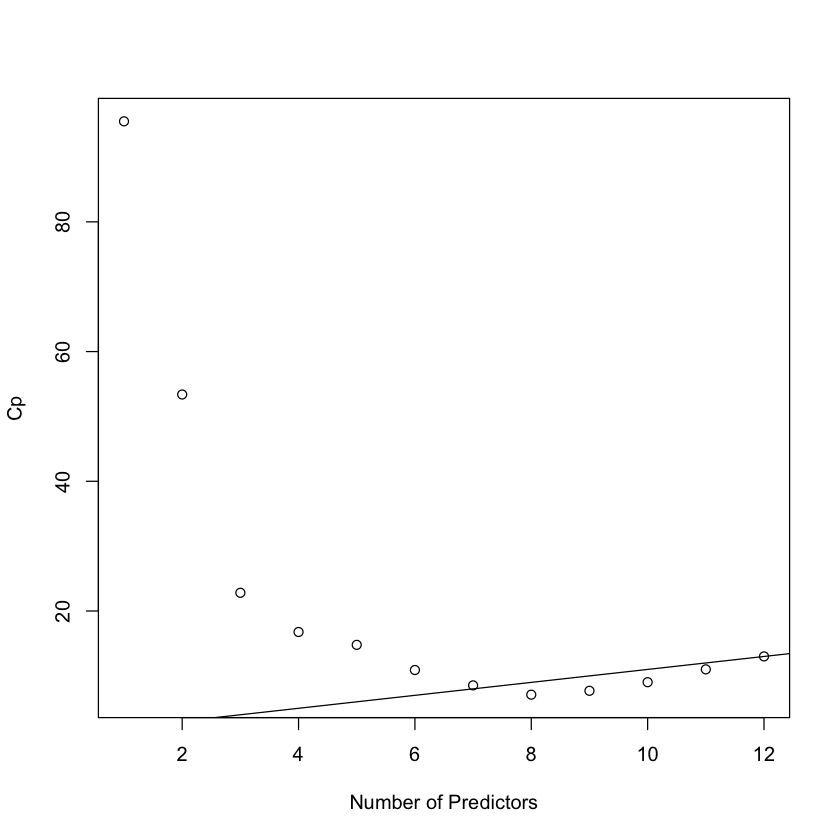

In [5]:
#Best Subsets using Cp
models <- regsubsets(draft_number ~ ., data = nba.avg, nvmax = 12)
sum.mod <- summary(models)
plot(sum.mod$cp, xlab='Number of Predictors', ylab='Cp') #using 7 predictors for less complexity
abline(1,1)

The subset models that have Cp values close to their respective number of variables are seen as the potential models. To reduce complexity in this case, the 7-predictor model `model.cp` is chosen. All subset models are shown in the table below. 

In [6]:
sum.mod$which  #subset of best models
model.cp <- lm(draft_number ~ player_height + gp + pts + reb + ast + oreb_pct + usg_pct, data = nba.avg)

(Intercept),player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,FALSE
TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE
TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE
TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE
TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE


Next, two stepwise models are created using both AIC and BIC as criteria.

In [7]:
#Stepwise selection using AIC and BIC
model0 <- lm(draft_number ~ 1, data = nba.avg)
model.all <- lm(draft_number ~ ., data = nba.avg)
n <- nrow(nba.avg)
step.AIC <- step(model.all, scope = list(lower = model0, upper = model.all), trace=0)
step.BIC <- step(model.all, scope = list(lower = model0, upper = model.all), k = log(n), trace=0) 

Using `anova` and a general linear F-test at 95% significance, we determine that the AIC model is more informative than the BIC model. We then compare the AIC model with the Cp model using the same method and conclude that the Cp model is the most informative out of the three.

In [8]:
# Comparison of AIC and BIC models
model.AIC <- lm(formula(step.AIC), data = nba.avg)
model.BIC <- lm(formula(step.BIC), data = nba.avg)
anova(model.BIC, model.AIC) #Reject model.BIC

#Compare best subsets Cp model (7 predictors) with model.AIC (8 predictors)
anova(model.cp, model.AIC) #Reject model.AIC

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
1039,180760.1,NA,NA,NA,NA
1035,177721.5,4,3038.644,4.424054,0.001501551


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
1036,178311.6,NA,NA,NA,NA
1035,177721.5,1,590.1449,3.436839,0.06404193


## Residual Analysis & Transformation
We first look at the residuals vs fitted and normal Q-Q plots.

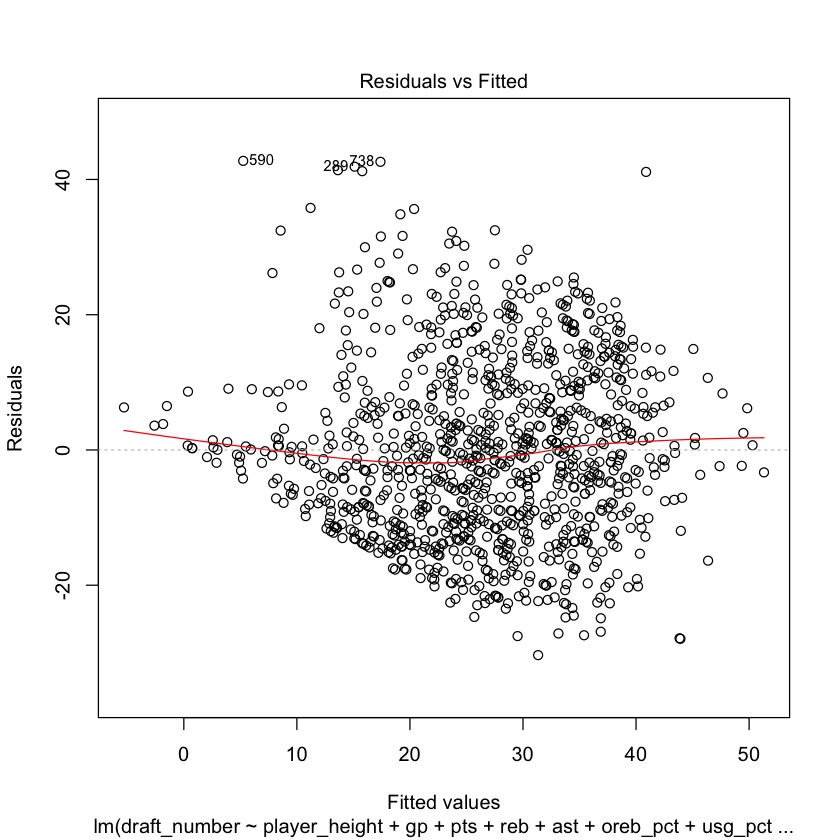

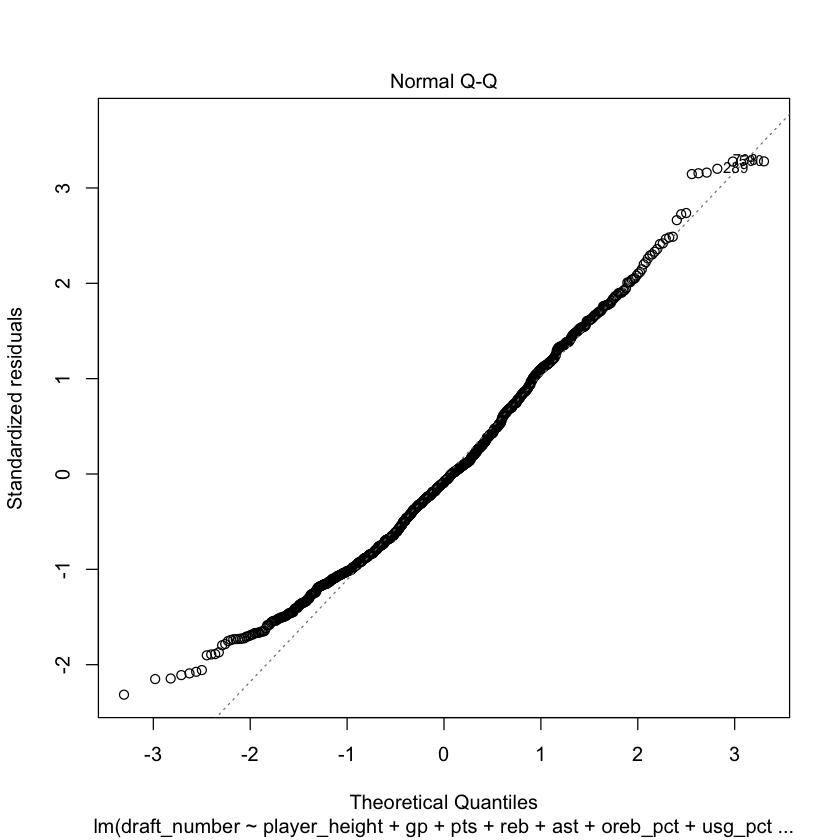

In [9]:
plot(model.cp, which = c(1,2)) 

Looking at the residual plots, we can see some heteroscedasticity and non-normality. To fix these violations, a Box-Cox transformation is done on the response. Since lambda from the transformation is approximately 0.5, draft number is square root transformed. Looking at the residual plots again, we can see that the variance is more or less uniform and the Shapiro-Wilk test for residuals' normality is passed.

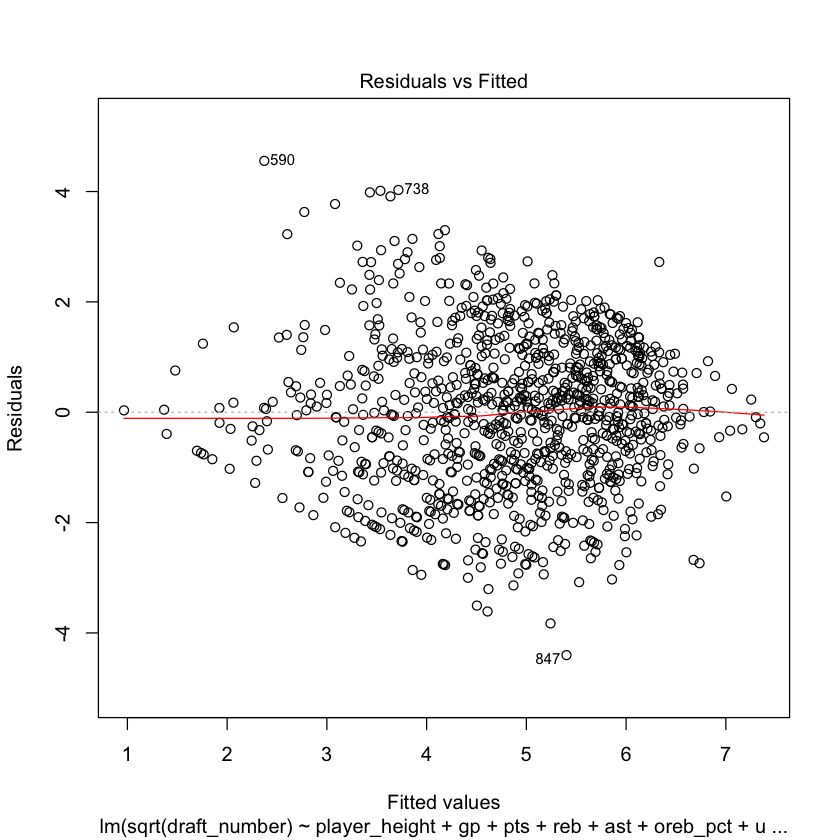


	Shapiro-Wilk normality test

data:  model.cp.bc$residuals
W = 0.99779, p-value = 0.1775


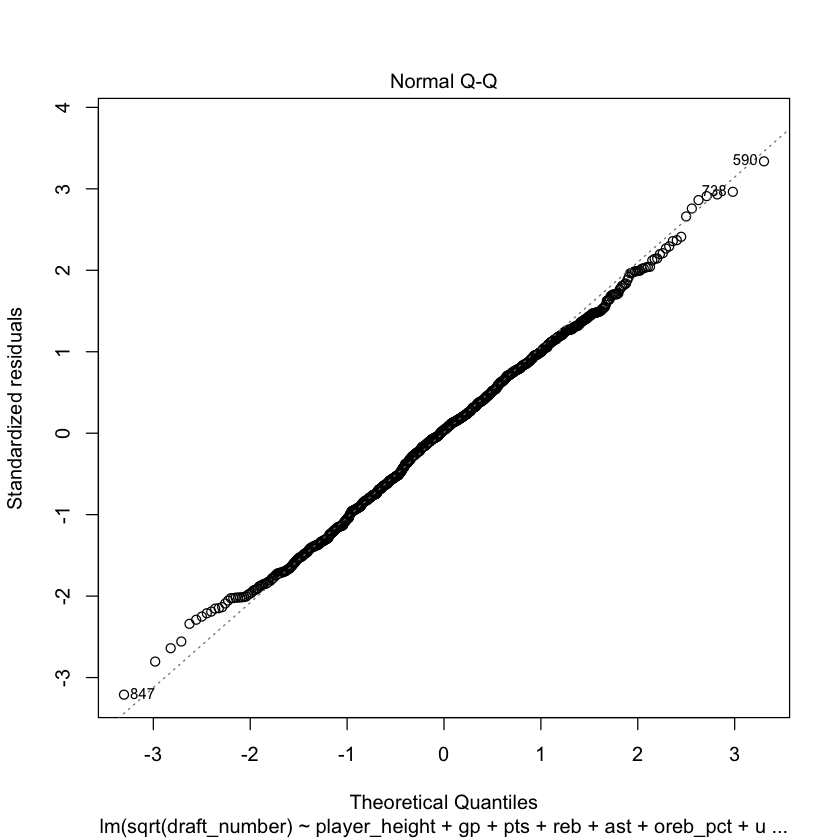

In [11]:
#Boxcox Transformation on Response
bc <- boxcox(model.cp, plotit = F)
lambda <- bc$x[which.max(bc$y)]  
model.cp.bc<- lm(sqrt(draft_number) ~ player_height + gp + pts + reb + ast + oreb_pct + usg_pct, data = nba.avg)
plot(model.cp.bc, which = c(1,2))
shapiro.test(model.cp.bc$residuals)

## Interactions, Multicollinearity, & Influential Points
Below we check for possible interactions in the transformed Cp model. Specifically, we are interested in interactions between the on-court variables that most effectively evaluate a player's contribution to games and skill: usage percentage, games played, points, assists, and rebounds. 

In [13]:
#Check usage percentage interactions
add1(model.cp.bc, ~ . + usg_pct:pts + usg_pct:reb + usg_pct:ast, test = 'F')

#Check games played interactions
add1(model.cp.bc, ~ . + gp:pts + gp:ast + gp:reb + gp:usg_pct, test = 'F')

#Check pts,ast, and reb interactions
add1(model.cp.bc, ~ . + pts:reb + pts:ast + reb:ast, test = 'F')

,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,1951.778,669.2115,NA,NA
pts:usg_pct,1,2.179466,1949.599,670.0451,1.157031662,0.2823327
reb:usg_pct,1,0.016172,1951.762,671.2029,0.008575849,0.9262346
ast:usg_pct,1,4.315617,1947.463,668.9005,2.293580667,0.1302152


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,1951.778,669.2115,NA,NA
gp:pts,1,5.9603694,1945.818,668.0184,3.170380,0.07527827
gp:ast,1,1.9997687,1949.779,670.1413,1.061536,0.30310579
gp:reb,1,8.9768600,1942.802,666.3987,4.782295,0.02897704
gp:usg_pct,1,0.3434093,1951.435,671.0278,0.182137,0.66963185


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
<none>,NA,NA,1951.778,669.2115,NA,NA
pts:reb,1,2.801704,1948.977,669.7118,1.487839,0.22282989
pts:ast,1,1.890198,1949.888,670.2000,1.003317,0.31674342
reb:ast,1,7.224329,1944.554,667.3401,3.845190,0.05015672


An interaction between games played and rebounds per game was found to be significant so it is incorporated into the model. However, when using variance inflation factors (VIF) to check for multicollinearity in the updated model, we find very high VIF values for rebounds and the new interaction term. As a result, we decide not to add the interaction between rebounds and games played.

In [14]:
model.cp.int <- update(model.cp.bc, ~ . + gp:reb)
vif(model.cp.int)

player_height            gp           pts           reb           ast 
     2.326698      3.790433      6.171484     21.024329      3.037619 
     oreb_pct       usg_pct        gp:reb 
     2.107254      1.676602     23.054871

According to Cook's distance, we remove one influential point and run our final model. 

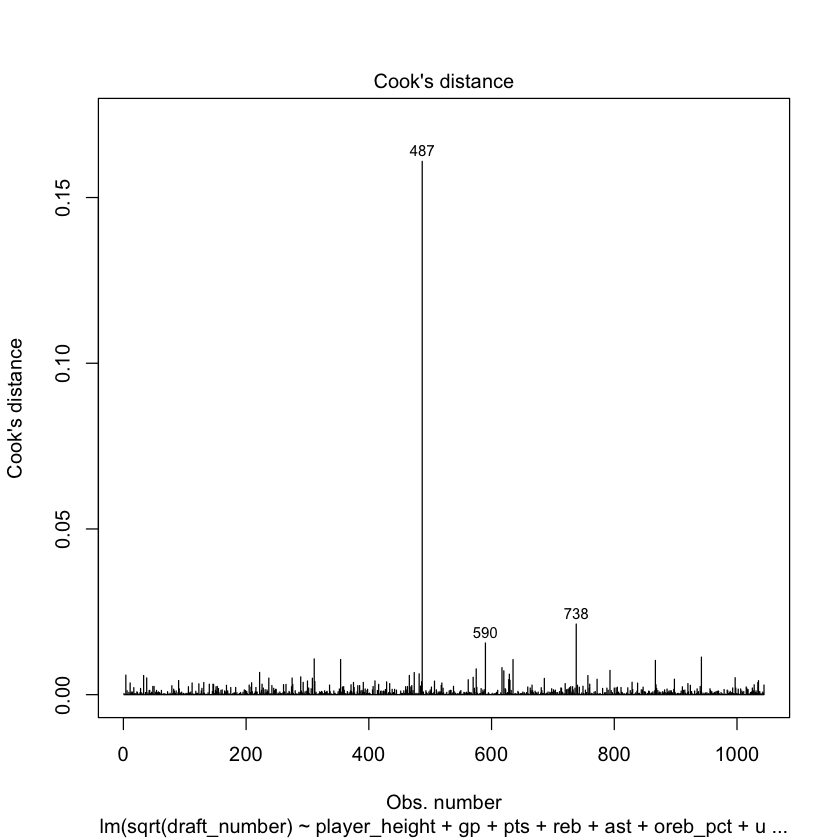

In [15]:
#Removing influential points
plot(model.cp.bc, which = 4)
model.cp.final <- lm(formula(model.cp.bc), data = nba.avg[-487,])

## Analysis and Interpretation

For our first question of interest, we will observe the final model’s t-test p-values for each feature since they indicate the significance of the relationship with `draft_number`. Features with the lowest p-values can be assumed to have the strongest relationships with the response. For our second question, the sign and magnitude of the model coefficients will help us conduct inference on how the features will change for future draft picks as draft position increases or decreases. Draft position decreases (being drafted higher) as features with negative coefficients increase. In other words, we can expect that as future players are drafted higher, they will more likely produce negative features. 

In [16]:
summary(model.cp.final)


Call:
lm(formula = formula(model.cp.bc), data = nba.avg[-487, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.3844 -0.9405  0.0526  0.9700  4.5741 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   15.001418   1.494813  10.036  < 2e-16 ***
player_height -0.038958   0.007281  -5.351 1.08e-07 ***
gp            -0.014082   0.003260  -4.320 1.71e-05 ***
pts           -0.067758   0.022836  -2.967 0.003074 ** 
reb           -0.157998   0.043352  -3.645 0.000281 ***
ast           -0.139339   0.051705  -2.695 0.007156 ** 
oreb_pct       4.730818   1.468739   3.221 0.001317 ** 
usg_pct       -4.057933   1.322042  -3.069 0.002200 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.371 on 1035 degrees of freedom
Multiple R-squared:  0.3742,	Adjusted R-squared:   0.37 
F-statistic: 88.42 on 7 and 1035 DF,  p-value: < 2.2e-16


#### **Which features are the most related to draft position?**

According to the p-values, the three most significant predictors in the model are `player_height`, games played `gp`, and rebounds `reb`. Because basketball is a sport that favors taller players, it is sensible that height has the strongest relationship with draft position. This fact may correspond to the significance of rebounds, a statistic that is generally high among taller players. The number of games played in a season is also not surprising given that players who are drafted higher overall are on average more talented and will consequently be allowed to play more games than those drafted later.

#### **Which box score statistics can we project future players to contribute as they are drafted higher or lower?**

As mentioned before, negative estimates correspond to features that we can expect to increase as players are drafted higher. On the other hand, positive estimates correspond to features that are more consistent at lower draft positions. We will consider several features.

The largest of these negative estimates is usage percentage `usg_pct`, meaning that top draft picks will see higher usage. Stemming from the same intuition for the significance of games played, top picks are considered more talented and will likely have higher usage or more percentage of possessions with the ball in their hands. 

Next, looking at the core box score statistics of points, rebounds, and assists, we can see that they are also all negative. Interestingly, points has the smallest estimate of the three while rebound has the largest, showing that rebounds and assists have a sharper increase or decrease than points as we move up or down the draft. The general interpretation here is that pure scorers (players who contribute to points only) are more likely to be found across the entire draft while better rebounders and passers are more prevalent at the top of the draft and fall off significantly from there. 

Offensive rebound percentage `oreb_pct` is the highest magnitude estimate but is also positive. An offensive rebound is defined as a rebound that a player grabs while their team is on an offensive possession. Because top draft picks see higher usage percentages, they are expected to be the primary initiator of offense most of the time and this leaves other players on the team, particularly role players, to grab offensive rebounds. Since talented players are taken at the top of the draft, we can say that role players are generally taken lower in the draft. This may explain the reasoning behind a particularly large positive estimate for offensive rebound percentage.

## Conclusion

The final model constructed helped to confirm intuition about the projection of biometric and box score features on draft position as well as offer insights into how those features are expected to change. However, this analysis is not exhaustive; the interpretations of the model estimates and the answers to our questions of interest can be confounded by effects outside the scope of this project. The data is limited to the 1996 - 2016 seasons, in which a large part was considered an era of defensive-style basketball. Consequently, the model is less generalizable to the current state of the game because it does not capture the full careers of recent players in addition to the emergence of focus on offensive play from those players. Some potential future work include gathering more data and extending the scope of the analysis, including biographic information such as age which can be highly predictive in sports, running other model diagnostics, or even trying other regression methods. 